In [1]:
suppressMessages(library("e1071"))
suppressMessages(library("mvtnorm"))
suppressMessages(library("dplyr"))
suppressMessages(library("ggplot2"))
suppressMessages(library("MCMCpack"))
suppressMessages(library("bayesplot"))
suppressMessages(library("rlang"))
suppressMessages(library("tsne"))
set.seed(23)

In [2]:
library(greta)
library(R6)
library(bayesplot)
library(coda)

options(repr.plot.width=10, repr.plot.height=4)


Attaching package: ‘greta’

The following object is masked from ‘package:coda’:

    mcmc

The following object is masked from ‘package:dplyr’:

    slice

The following objects are masked from ‘package:stats’:

    binomial, cov2cor, poisson

The following objects are masked from ‘package:base’:

    %*%, apply, backsolve, beta, chol2inv, colMeans, colSums, diag,
    eigen, forwardsolve, gamma, identity, rowMeans, rowSums, sweep,
    tapply



In [3]:
distribution_node <- .internals$nodes$node_classes$distribution_node
as.greta_array    <- .internals$greta_arrays$as.greta_array
check_dims <- .internals$utils$checks$check_dims
distrib    <- .internals$nodes$constructors$distrib
fl     <- .internals$utils$misc$fl
tf_sum <- greta:::tf_sum

In [4]:
error_probability_distribution <- R6Class(
  "error_probability_distribution",
  inherit = distribution_node,
  public = list(
    initialize = function(theta, alpha, beta, dim) {
      theta <- as.greta_array(theta)
      alpha <- as.greta_array(alpha)
      beta <- as.greta_array(beta)
        
      dim <- check_dims(theta, alpha, beta, target_dim = dim)
      super$initialize("error_probability", dim, discrete = TRUE)
      self$add_parameter(theta, "theta")
      self$add_parameter(alpha, "alpha")
      self$add_parameter(beta, "beta")
    },
    
    tf_distrib = function(parameters, dag) {
      theta <- parameters$theta
      alpha <- parameters$alpha
      beta <- parameters$beta
        
      log_prob <- function(x) {
        tf_sum(
            log(
                theta * ((fl(1) - beta)**x * beta**(fl(1) - x)) +
                (fl(1) - theta) * ((fl(1) - alpha)**(fl(1) - x) * alpha**x)
            )            
        )
      }
      
      list(log_prob = log_prob, cdf = NULL, log_cdf = NULL)
    },
    
    tf_cdf_function = NULL,
    tf_log_cdf_function = NULL
  )
)

In [5]:
error_probability <- function(theta, alpha, beta, dim = NULL) {
  distrib("error_probability", theta, alpha, beta, dim)
}

In [6]:
n <- 30
p <- 3
k <- 3
(probs <- seq(0.1, 0.9, length.out = k))

d <- rbind(
  matrix(rbinom(n * p, 1, probs[1]), n),
  matrix(rbinom(n * p, 1, probs[2]), n),
  matrix(rbinom(n * p, 1, probs[3]), n)
)

[1] 0.1 0.5 0.9

In [7]:
theta1 <- greta::beta(1, 1, dim = p)
theta2 <- greta::beta(1, 1, dim = p)
theta3 <- greta::beta(1, 1, dim = p)

alpha1 <- greta::beta(1, 1, dim = p)
alpha2 <- greta::beta(1, 1, dim = p)
alpha3 <- greta::beta(1, 1, dim = p)

beta1 <- greta::beta(1, 1, dim = p)
beta2 <- greta::beta(1, 1, dim = p)
beta3 <- greta::beta(1, 1, dim = p)

pi <- greta::uniform(0, 1, 3)

In [8]:
for (i in seq(nrow(d)))
{
  distribution(d[i,]) <- greta::mixture(
    error_probability(theta1, alpha1, beta1),
    error_probability(theta2, alpha2, beta2),
    error_probability(theta3, alpha3, beta3),
    weights = pi)
}

In [9]:
mod <- greta::model(
    pi,
    theta1, theta2, theta3,
    alpha1, alpha2, alpha3,
    beta1, beta2, beta3)

In [10]:
samples <- greta::mcmc(mod, chains = 1, n_cores = 1)

    warmup ====================================== 1000/1000 | eta:  0s | 3% bad 
  sampling ====================================== 1000/1000 | eta:  0s          


In [11]:
coda::gelman.diag(samples)

ERROR: Error in coda::gelman.diag(samples): You need at least two chains


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


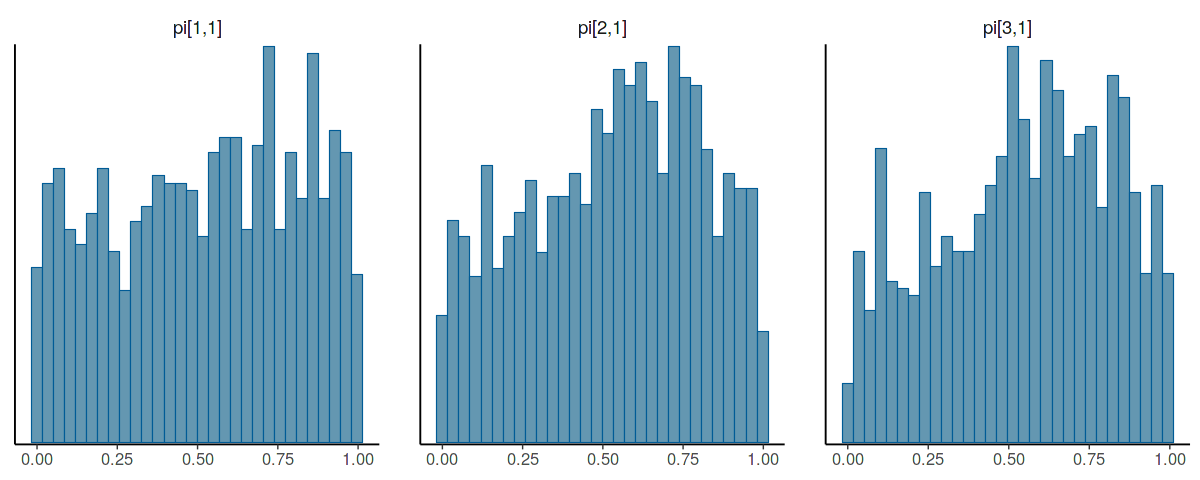

In [12]:
bayesplot::mcmc_hist(samples, regex_pars =  "pi")

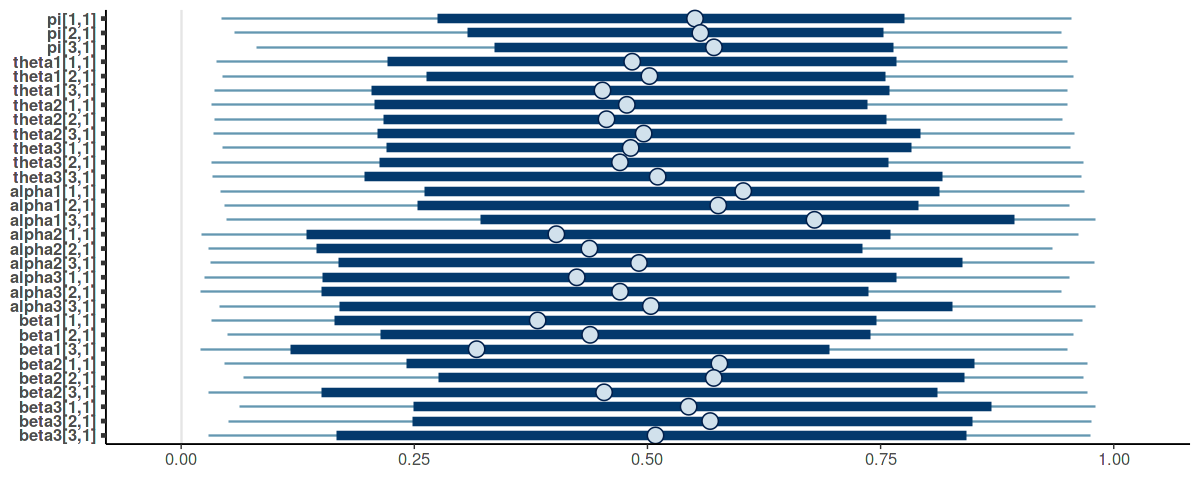

In [15]:
bayesplot::mcmc_intervals(samples)